<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/CNN_Hyperparameters_Keras_Tuner_Coil100_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Create CNN Model and Optimize it using Keras Tuner

##Setup

In [1]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=e382add0020bd3529dbd4af032a0bb20320f8578b9f0ebf1606a3be2d34e4b47
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=1f3906755af32f68c340a03aa2ae300500fe938ff99371ca5b0deaa1aebf834a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
# Common Import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Scikit Learn libraries
import sklearn
from sklearn import metrics

# Others
import os
from zipfile import ZipFile
import zipfile
import tarfile
import cv2
import random
from google.colab.patches import cv2_imshow

# To make this notebook's output stable across runs
np.random.seed(168)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# If not update sklearn -> !pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

## Custom Functions

Downloading data to a specific path

In [0]:
import urllib
import urllib.parse as parse

def download(url, save_path, target_file_name=''):
  print("Downloading ...")
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path, target_file_name)
  with open(targetFile, 'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

Extract zip file

In [0]:
def extractZip(zip_file_path, target_path):
    print("Start extracting....")
    zFile=ZipFile(zip_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

Extract tar file

In [0]:
def extractTar(tar_file_path, target_path):
    print("Start extracting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

Create dataset from the data's path that downloaded to

In [0]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(128,128)) # resize images if it has to
    x.append(np.array(img_imr))
  return x


###Preprocessing Data

In [8]:
!wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip -O /content/coil-100.zip

--2020-05-12 01:04:23--  http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip [following]
--2020-05-12 01:04:23--  https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130688843 (125M) [application/zip]
Saving to: ‘/content/coil-100.zip’

/content/coil-100.z 100%[===================>] 124.63M  50.3MB/s    in 2.5s    

2020-05-12 01:04:26 (50.3 MB/s) - ‘/content/coil-100.zip’ saved [130688843/130688843]



In [0]:
data_path = '/content/coil-100.zip'
zip_data = zipfile.ZipFile(data_path,'r')
zip_data.extractall('/content/coil100')
zip_data.close()

In [10]:
# Remove files that are not image
coil_dir = '/content/coil100/coil-100'
coil_list = os.listdir(coil_dir)
for item in coil_list:
    if not item.lower().endswith('.png'):
      path = os.path.join(coil_dir, item)
      os.remove(path)
      print('Successfully deleted file in: {}'.format(path))

Successfully deleted file in: /content/coil100/coil-100/convertGroupppm2png.pl
Successfully deleted file in: /content/coil100/coil-100/convertGroupppm2png.pl~


In [0]:
coil_list = os.listdir('/content/coil100/coil-100') # to refresh the folder again

In [12]:
print('Total images:',len(coil_list))

Total images: 7200


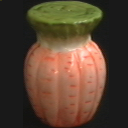

image size (128, 128, 3) 


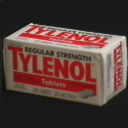

image size (128, 128, 3) 


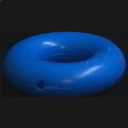

image size (128, 128, 3) 


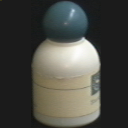

image size (128, 128, 3) 


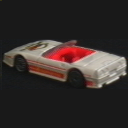

image size (128, 128, 3) 


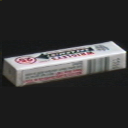

image size (128, 128, 3) 


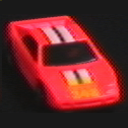

image size (128, 128, 3) 


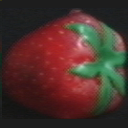

image size (128, 128, 3) 


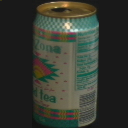

image size (128, 128, 3) 


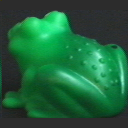

image size (128, 128, 3) 


In [13]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_list)-1)
  img = cv2.imread(os.path.join(coil_dir, coil_list[rndIndx]))
  cv2_imshow(img)
  print('image size {} '.format(img.shape))

See the the first 10 images filename

In [14]:
print(coil_list[:10])

['obj7__200.png', 'obj33__55.png', 'obj26__345.png', 'obj53__85.png', 'obj44__270.png', 'obj3__100.png', 'obj69__330.png', 'obj18__25.png', 'obj10__345.png', 'obj26__180.png']


Therefore, the first 4 letters represented the labels of the images

##Create label y

In [0]:
label_name = []
for name in coil_list:
  label_name.append(name.split("j")[1].split("__")[0])

In [16]:
num_classes = len(np.unique(label_name))
num_classes

100

In [0]:
labels = np.asarray(label_name) # convert to array
y = labels.astype(np.int32) # convert from array str to array int

In [18]:
y

array([ 7, 33, 26, ..., 19, 32, 33], dtype=int32)

Two below cells are the alternative ways to create y labels

In [0]:
#import sklearn.preprocessing
#lb = sklearn.preprocessing.LabelBinarizer()
#lb.fit(range(max(labels)))
#y = lb.transform(labels)

In [0]:
#from keras.utils import to_categorical
#y = to_categorical(labels, num_classes=num_classes)

##Create training X

In [0]:
coil100 = create_img_set(os.path.join(coil_dir))

View some random images

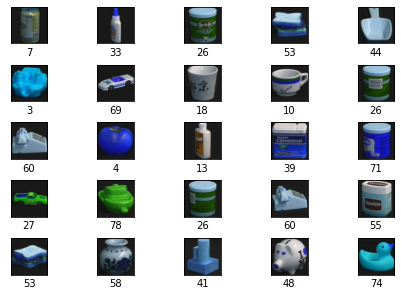

In [43]:
fig, ax = plt.subplots(5, 5, constrained_layout=True)
for i, axi in enumerate(ax.flat):
    axi.imshow(coil100[i])
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i])

###Flatten dataset

In [23]:
X = np.array(coil100)
X.shape

(7200, 128, 128, 3)

###Scale dataset

In [24]:
np.amin(X), np.amax(X) # see the mix and max value before scale

(0, 253)

Scale to (0,1) by deviding with max. value 253

In [0]:
X =  X.astype('float32')/253.0

In [26]:
np.amin(X), np.amax(X)

(0.0, 1.0)

##Split dataset X and y

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=168)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 128, 128, 3), (1440, 128, 128, 3), (5760,), (1440,))

#Create CNN Model with some range of parameters

###This one return accuracy 0.00

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers, optimizers


def build_model(hp):  
  model = keras.Sequential([
                            
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32), input_shape=(128,128,3),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), 
  
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5,7]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
   
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5,7]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Flatten(),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=128),
        activation='relu'),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=128),
        activation='relu'),

    keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=128, max_value=1024, step=128),
        activation='relu'),

    keras.layers.Dense(100, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

Using TensorFlow backend.


###I tried this one always error

In [0]:
'''from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                               input_shape=(128,128,3),
                               activation='relu'))
    model.add(layers.Dense(100, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model '''

###Search for the best hyperparameters using 5 trials only

In [0]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=3)

In [0]:
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

In [0]:
bestModel = tuner.get_best_models(num_models=1)[0]

Here's the best model

In [0]:
bestModel.summary()

Fit the training set to the best model once again to verify

In [0]:
bestModel.fit(X_train, y_train, epochs=10, validation_split=0.2)

See the accuracy

In [0]:
score_acc = bestModel.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_acc[0])
print('Test accuracy:', score_acc[1])